# Задание №1 Boosting

Варьируя параметры ансамбля в подходам блэндинг и стэкинг, обучить оптимальный классификатор.

Визуализировать графики зависимости предсказания от параметров модели.

# Решение

In [28]:
from datasets import load_dataset

dataset = load_dataset('json', data_files={'train': 'train.jsonl','test':'validation.jsonl'})

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

vectorizer = CountVectorizer(max_features=500, min_df=4, max_df=0.7, stop_words=stopwords.words('english'))
X_train_vec = vectorizer.fit_transform(dataset['train']['text'])

vocabulary = vectorizer.get_feature_names_out() 

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
X_train_idf = tfidf.fit_transform(X_train_vec)

In [31]:
X_test_vec = vectorizer.transform(dataset['test']['text'])
X_test_idf = tfidf.transform(X_test_vec)

In [32]:
X_train = X_train_idf.toarray()
X_test = X_test_idf.toarray()

y_train, y_test = dataset['train']['label'], dataset['test']['label']

In [33]:
from sklearn.model_selection import train_test_split

X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [34]:
def get_params():
    return [2, 5, 10, 20], [2, 4, 6, 8], [5, 10, 20], [4, 6, 8]

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def visual(results, method):
    n_estimators_list, max_depth_list, _, _ = get_params()

    plt.figure(figsize=(10, 6))

    for max_depth in max_depth_list:
        subset = [
            np.mean([r['accuracy'] for r in results
                    if r['base_max_depth'] == max_depth and r['base_n_estimators'] == n])
            for n in n_estimators_list
        ]
        plt.plot(n_estimators_list, subset, label=f'Макс. глубина = {max_depth}')

    plt.xlabel('Количество деревьев (базовые модели)')
    plt.ylabel('Точность')
    plt.title(f'Зависимость точности от количества деревьев в базовых моделях {method}')
    plt.legend()
    plt.show()

Blending

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def make_blending_prediction(basic_clfs, final_clf, data):
    y0 = []
    for c in basic_clfs:
        y0.append(c.predict(data))
    y0_t = np.array(y0).transpose()
    return final_clf.predict(y0_t)

def get_results_blending():
    n_estimators_list, max_depth_list, final_n_estimators, final_max_depth = get_params()
    results = []
    
    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            crf = []
            y_pred_1 = []
            for n in range(1, 11):  # Количество базовых классификаторов в ансамбле
                clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=n)
                clf.fit(X_train_0, y_train_0)
                crf.append(clf)
                y_pred_1.append(clf.predict(X_train_1).reshape(-1, 1))
            y_pred_1t = np.array(y_pred_1).transpose()[0]

            # Перебор параметров финального классификатора
            for fn in final_n_estimators:
                for fd in final_max_depth:
                    clf_final = RandomForestClassifier(n_estimators=fn, max_depth=fd, random_state=42)
                    clf_final.fit(y_pred_1t, y_train_1)

                    # Оценка на тестовых данных
                    y_test_pred = make_blending_prediction(crf, clf_final, X_test)
                    acc = metrics.accuracy_score(y_test, y_test_pred)

                    # Сохраняем результаты
                    results.append({
                        'base_n_estimators': n_estimators,
                        'base_max_depth': max_depth,
                        'final_n_estimators': fn,
                        'final_max_depth': fd,
                        'accuracy': acc
                    })
    return results

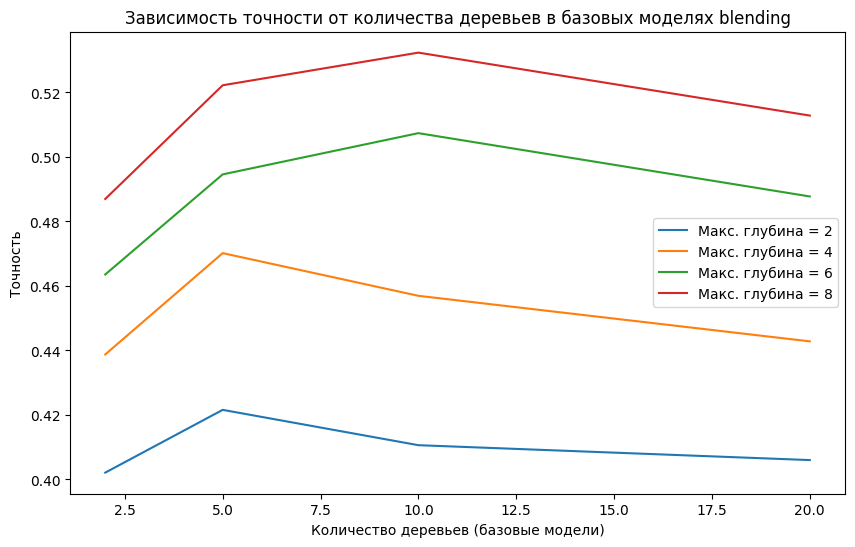

In [ ]:
visual(get_results_blending(), 'blending')

Stacking

In [40]:
from sklearn.model_selection import KFold

def make_stacking_prediction(basic_clfs, final_clf, data):
    y0 = []
    for c in basic_clfs:
        y0.append(c.predict(data))
    y0_t = np.array(y0).transpose()
    return final_clf.predict(y0_t)

def get_results_stacking():
    n_estimators_list, max_depth_list, final_n_estimators, final_max_depth = get_params()
    results = []

    kf = KFold(n_splits=10, random_state=None, shuffle=True)

    # Перебор параметров базовых классификаторов
    for base_n_estimators in n_estimators_list:
        for base_max_depth in max_depth_list:
            pre_prediction = np.zeros((len(X_train), kf.get_n_splits()))
            crf_stack = []

            # KFold для стекинга
            for i, (train_index, test_index) in enumerate(kf.split(X_train)):
                X_train_0, X_test_1 = np.array(X_train)[train_index], np.array(X_train)[test_index]
                y_train_0, y_test_1 = np.array(y_train)[train_index], np.array(y_train)[test_index]

                # Базовые классификаторы
                clf = RandomForestClassifier(n_estimators=base_n_estimators, max_depth=base_max_depth, random_state=i)
                clf.fit(X_train_0, y_train_0)
                crf_stack.append(clf)
                pre_prediction[test_index, i] = clf.predict(X_test_1)

            # Перебор параметров финального классификатора
            for final_n in final_n_estimators:
                for fd in final_max_depth:
                    clf_stack_final = RandomForestClassifier(n_estimators=final_n, max_depth=fd, random_state=42)
                    clf_stack_final.fit(pre_prediction, y_train)

                    # Оценка на тестовых данных
                    y_test_pred = make_stacking_prediction(crf_stack, clf_stack_final, X_test)
                    acc = metrics.accuracy_score(y_test, y_test_pred)

                    # Сохраняем результаты
                    results.append({
                        'base_n_estimators': base_n_estimators,
                        'base_max_depth': base_max_depth,
                        'final_n_estimators': final_n,
                        'final_max_depth': fd,
                        'accuracy': acc
                    })

    return results

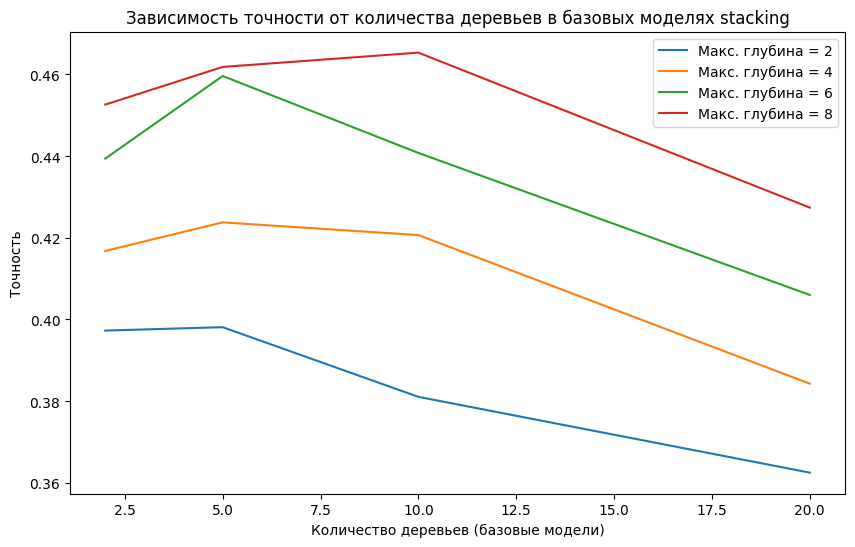

In [41]:
visual(get_results_stacking(), 'stacking')

# Задание №2 Trees

In [44]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data[:, 2:]
y = iris.target

target_names = iris.target_names
feature_names = iris.feature_names[2:]

1. Постройте и визуализируйте структуру решающего дерева для критерия разбиения "entropy"

[Text(0.4, 0.8333333333333334, 'x[0] <= 2.45\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa'),
 Text(0.2, 0.5, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[1] <= 1.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.445\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.151\nsamples = 46\nvalue = [0, 1, 45]\nclass = virginica')]

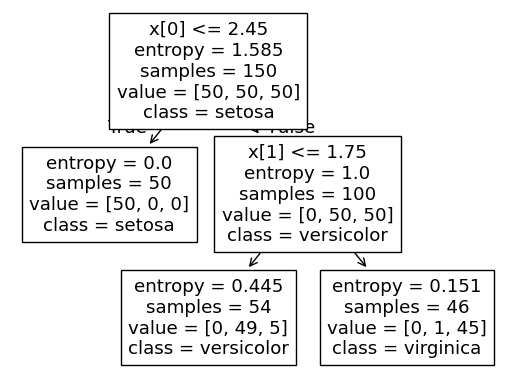

In [ ]:
from sklearn import tree

# criterion: “gini”, “entropy”, “log_loss”. default=”gini”
tree_clf_gini = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=2, random_state=42)
tree_clf_gini.fit(X, y)

tree.plot_tree(tree_clf_gini, class_names = target_names)

2. Обучите серию классификаторов без регуляризации по минимальному количеству экземпляров в листе. Визуализируйте MAE

In [85]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

def visual_clfs_mae(min_samples_leaf_values, mae_values, mae_train):
    plt.figure(figsize=(10, 6))
    plt.plot(min_samples_leaf_values, mae_train, label='Train', marker='o', linestyle='-', color='r')
    plt.plot(min_samples_leaf_values, mae_values, label='Valid', marker='o', linestyle='-', color='b')
    plt.title('MAE vs min_samples_leaf')
    plt.legend()
    plt.xlabel('min_samples_leaf')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.grid(True)
    plt.xscale('log')  # Логарифмическая шкала для оси X, так как значения min_samples_leaf могут сильно отличаться
    plt.show()

def train_clfs(train, y, real_columns, min_samples_leaf_values = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 1500]):

    x_train, x_val, y_train, y_val = train_test_split(train[real_columns], y, train_size=0.8, test_size=0.2, random_state=42)

    mae_values = []
    mae_train = []

    for min_samples_leaf in min_samples_leaf_values:
        model = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, random_state=42)
        model.fit(x_train, y_train)
        mae_train.append(mean_absolute_error(y_train, model.predict(x_train)))
        mae_values.append(mean_absolute_error(y_val, model.predict(x_val)))

    visual_clfs_mae(min_samples_leaf_values, mae_values, mae_train)

In [77]:
import pandas as pd

train = pd.read_csv('./departure-delayed/train_features.csv').fillna(0)
y = pd.read_csv('./departure-delayed/train_target.csv', index_col='id')

train.drop('Year', axis=1, inplace=True) # удаляем, т.к. признак `year` не несет вариативности в данные

real_columns = list(train.dtypes[train.dtypes != 'object'].index.values)
# cat_cols = list(train.dtypes[train.dtypes == 'object'].index.values)

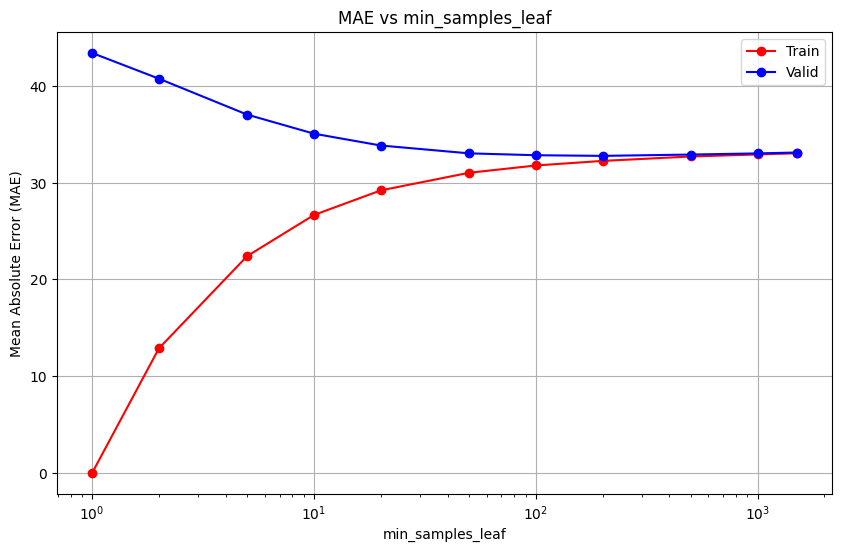

In [86]:
train_clfs(train, y, real_columns)

3. Обучите дерево с наилучшими параметрами из предыдущего примера

In [94]:
def get_mae_best_model(train, y, real_columns, max_depth=21, min_samples_leaf=1000):
    x_train, x_val, y_train, y_val = train_test_split(train[real_columns], y, train_size=0.8, test_size=0.2, random_state=42)

    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    model.fit(x_train, y_train)
    return x_train, x_val, y_train, y_val, model, mean_absolute_error(model.predict(x_val), y_val)

In [95]:
x_train, x_val, y_train, y_val, best_model, mae = get_mae_best_model(train, y, real_columns)
print(f'МАЕ модели с лучшими параметрами: {mae}')

МАЕ модели с лучшими параметрами: 33.02198247215921


4. Выбрать оптимальное количество регрессоров, оптимальные параметры для Bagging Regressor. Выбрать оптимальные параметры для каждого дерева.

In [96]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

bag_of_trees = BaggingRegressor(best_model, n_estimators=5, random_state=42)

bag_of_trees.fit(x_train, y_train)

c:\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=21,
                                                 min_samples_leaf=1000,
                                                 random_state=42),
                 n_estimators=5, random_state=42)

In [98]:
from sklearn.model_selection import GridSearchCV

y_train_flat = y_train.values.ravel() # чтобы точно был одномерный массив

param_grid = {
    'n_estimators': [4, 6, 8, 10],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

bagging_regressor = BaggingRegressor(estimator=best_model, random_state=42, n_jobs=-1)

grid_search = GridSearchCV(bagging_regressor, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train_flat)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший MAE: {grid_search.best_score_}')

Лучшие параметры: {'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 8}
Лучший MAE: -33.11377260514818


5. Обучить, выявить оптимальное количество моделей в регрессоре, оптимальные параметры для регрессора

In [99]:
forest = RandomForestRegressor(n_estimators=5, n_jobs=-1, random_state=42, criterion='squared_error', max_depth=9)
forest.fit(x_train, y_train)
rf_mse_val = mean_absolute_error(forest.predict(x_val), y_val)
rf_mse_val

c:\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


np.float64(33.21772406454778)

In [100]:
param_grid = {
    'n_estimators': [4, 6, 8, 10],
    'max_depth': [None, 4, 6, 8],
    'max_features': ['auto', 'sqrt', 'log2']
}

forest_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(forest_regressor, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train_flat)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший MAE на валидационной выборке: {grid_search.best_score_}')

c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
48 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_p

Лучшие параметры: {'max_depth': 8, 'max_features': 'log2', 'n_estimators': 8}
Лучший MAE на валидационной выборке: -33.39800170180205
